In [39]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# define cmaps for viruses
hsv1_palette = sns.light_palette((168/256, 97/256, 92/256), reverse=True, as_cmap=True)
hcmv_palette = sns.light_palette((71/256, 103/256, 133/256), reverse=True, as_cmap=True)
kshv_palette = sns.light_palette((113/256, 175/256, 71/256), reverse=True, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load Data

In [34]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

In [8]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]
temporality.name = 'temporality'

In [10]:
ignore_host = ['MYH9','TUBA1A', 'MYO5A', 'CALU', 'IFI16', 'PML', 'SP100', 'ZC3HAV1', 'C1QBP', 'WDFY1']

info = pd.concat([pd.read_csv(r'..\data\assay info_{}.csv'.format(v)) for v in ['HSV-1', 'HCMV', 'KSHV']], keys = ['HSV-1', 'HCMV', 'KSHV'], names = ['virus']).reset_index()
info['Protein Gene'] = info['Protein Gene'].fillna(info['Protein Name']).str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
info = info.set_index(['virus', 'Protein Accession', 'Protein Gene'])['Peptide Modified Sequence']
info = info[~info.index.get_level_values('Protein Gene').isin(ignore_host)]
info = info.str.replace('[+57]', '', regex=False)

info = pd.concat([info, temporality.reindex(info.index, level='Protein Accession')], axis=1).reset_index().set_index(info.index.names+['temporality']).squeeze()
info_r = info.reset_index().set_index('Peptide Modified Sequence')

In [23]:
# strain conservation analysis results
final_df = pd.read_csv(r'..\data\strain_conservation_analysis_results.csv', header=[0, 1, 2, 3, 4], index_col=[0, 1, 2])
temp = final_df.T.reset_index()
temp['temporality'] = info_r.reindex(temp['Peptide Modified Sequence'])['temporality'].values
final_df = temp.set_index(final_df.T.index.names).T

sel_strains = {'HSV-1': ['17', 
                         'KOS', 
                         'Sc16',
                         'F',
                         'H129',
                         'McKrae',
                         'MacIntyre'
                        ],
               
               'HSV-2': ['HG52'],
               
               'HCMV': ['AD169', 
                        'Towne', 
                        'Merlin', 
                        'Toledo', # low passage
                        'TB40_E', # low passage
                        'TR', # low passage
                       ], 
               
               'KSHV': ['BAC16',
                        'BrK',
                        'GK18', 
                        'DG1'
                       ]
              }

to_plot = final_df[[i in j for i, j in zip(final_df.index.get_level_values('strain'), final_df.index.get_level_values('virus').map(sel_strains))]].reset_index('# genomes', drop=True)
to_plot.to_csv(r'..\tables\TableS4.csv') # export supplemental table

temp = to_plot.reset_index()
temp['strain'] = temp['strain'].where(lambda x: x!='Sc16', 'SC16').where(lambda x: x!='HG52', 'HSV-2\n(HG52)').where(lambda x: x!='TB40_E', 'TB40/E').where(lambda x: x!='BrK', 'BrK.219')
to_plot = temp.set_index(to_plot.index.names)

fprot = to_plot.T.groupby(['virus', 'temporality', 'Protein Gene',]).apply(lambda x: x.sum()/x.shape[0]).sort_index().T
nprot = to_plot.T.groupby(['virus', 'temporality', 'Protein Gene',]).apply(lambda x: x.sum()).sort_index().T

In [37]:
# TB40 PRM data
folder = r'..\Skyline_reports'
TB40 = load_herpesvirusPRMreport(os.path.join(folder, 'HCMV_TB40.csv'), 'HCMV', n_points=1)
TB40 = TB40.groupby(TB40.index.names[:-1]).mean().unstack(['treatment', 'timepoint', 'replicate']).mean(axis=1)
temp = TB40.reset_index()
temp['Protein Gene'] = temp['Protein Gene'].fillna(temp['Protein Gene']).str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
temp['Peptide Modified Sequence'] = temp['Peptide Modified Sequence'].str.replace('[+57]', '', regex=False)
TB40 = temp.set_index(TB40.index.names)
TB40 = TB40.reset_index().set_index(to_plot['HCMV'].columns.names).squeeze().reindex(to_plot['HCMV'].columns)
TB40_bool = TB40.fillna(False).where(lambda x: x == False, True)

comb=pd.concat([to_plot.loc[('HCMV', 'TB40/E'), 'HCMV'], TB40_bool], axis=1, keys = ['pred', 'exp'])

Duplicate entries detected, dropping duplicates


# Make Figures

### Fig. 6A

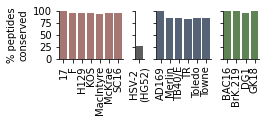

In [29]:
temp = to_plot.T.groupby(['virus', 'temporality', 'Protein Gene', 'Peptide Modified Sequence']).any()
temp = temp.groupby('virus', axis=0).sum().apply(lambda x: x/temp.groupby('virus', axis=0).size())*100


n = len([j for i in list(sel_strains.values()) for j in i])
fig, axs = plt.subplots(ncols=4, figsize = (3.8, 1.8), squeeze=True, 
                        gridspec_kw={'width_ratios': [len(sel_strains['HSV-1'])/n,
                                                      len(sel_strains['HSV-2'])/n,
                                                      len(sel_strains['HCMV'])/n, 
                                                      len(sel_strains['KSHV'])/n]}, 
                        sharey=True)
    
for ticks, ax, v, p in zip([60, 60, 100, 70], axs, ['HSV-1', 'HSV-2', 'HCMV', 'KSHV'], [pal[0], pal[-1]]+pal[1:3]):
    if not v == 'HSV-2':
        data=temp.loc[v, v].T
    else:
        data=temp.loc['HSV-1', v].T

    data.index.names = ['strain']
    
    
    
    o = data.sort_values(ascending=False).index.values
    data = data.reset_index()
    data.columns = ['strain', '% peptides']

    sns.barplot(data=data, x='strain', y='% peptides',
                order = np.sort(o),
                color=p,
                ax=ax)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.set_ylim(0, 100)
    ax.set_yticks(np.linspace(0, 100, 5))
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_yticklabels([int(i) for i in np.linspace(0, 100, 5)])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

axs[0].set_ylabel('% peptides\nconserved')

fig.tight_layout()  
plt.subplots_adjust(wspace=0.3)

fig.savefig(r'..\figures\Fig6A.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 6B

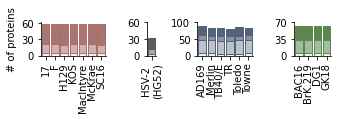

In [30]:
n = len([j for i in list(sel_strains.values()) for j in i])
fig, axs = plt.subplots(ncols=4, figsize = (4.8, 1.6), squeeze=True, 
                        gridspec_kw={'width_ratios': [len(sel_strains['HSV-1'])/n,
                                                      len(sel_strains['HSV-2'])/n,
                                                      len(sel_strains['HCMV'])/n, 
                                                      len(sel_strains['KSHV'])/n]})
    
for ticks, ax, v, p, ts in zip([60, 60, 100, 70], axs, ['HSV-1', 'HSV-2', 'HCMV', 'KSHV'], [pal[0], pal[-1]]+pal[1:3], [['IE', 'E', 'L'], ['IE', 'E', 'L'], ['IE', 'DE', 'LL', 'L'], ['IE', 'DE', 'L']]):
    if not v == 'HSV-2':
        data=to_plot.T.groupby(['virus', 'temporality', 'Protein Gene',]).any().groupby(['virus', 'temporality']).sum().loc[v, v].T
    else:
        data=to_plot.T.groupby(['virus', 'temporality', 'Protein Gene',]).any().groupby(['virus', 'temporality']).sum().loc['HSV-1', v].T

    data.index.names = ['strain']
    
    for i, c in enumerate(data[ts]):
        if not c==ts[0]:
            data[c] = data[c]+data[ts[i-1]]
    
    o = data.sum(axis=1).sort_values(ascending=False).index.values[data.sum(axis=1).sort_values(ascending=False)!=0]
    data = data.stack()[data.stack()!=0].reset_index()

    sns.barplot(data=data, x='strain', y=0, hue='temporality',
                order = np.sort(o),
                palette = sns.light_palette(p, n_colors=data['temporality'].unique().shape[0], reverse=True), 
                hue_order = ts[::-1], 
                dodge=False, 
                ax=ax)
    
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_yticks(np.linspace(0, ticks, 3))
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    for patch in ax.patches:
        patch.set_edgecolor(p)

axs[0].set_ylabel('# of proteins')
fig.tight_layout()  
# plt.subplots_adjust(wspace=0.8)
fig.savefig(r'..\figures\Fig6B.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 6C-E

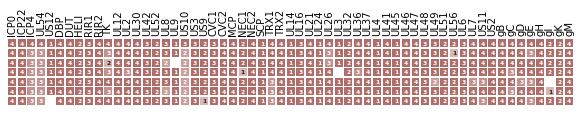

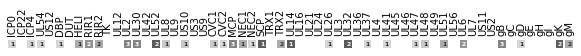

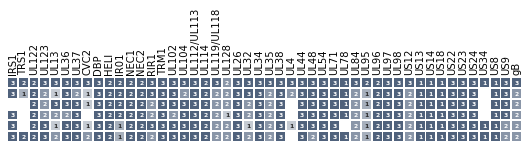

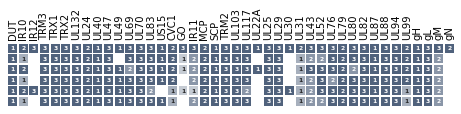

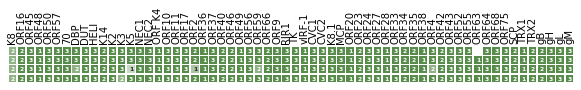

In [32]:
hms = {}
annots = {}

for v1, v2, palette, fs, ts in zip(['HSV-1', 'HSV-2', 'HCMV', 'KSHV'], ['HSV-1', 'HSV-1', 'HCMV', 'KSHV'], [pal[0], pal[-1]]+pal[1:3], [(1.3, 8), (1.3, 8), (2, 11), (1.3, 8)], [['IE', 'E', 'L'], ['IE', 'E', 'L'], ['IE', 'DE', 'LL', 'L'], ['IE', 'DE', 'L']]):
    if v1!='HCMV':
        pass
        w=8.2
        
        data = fprot.loc[v1, v2]
        data = data.loc[data.sum(axis=1).sort_values(ascending=False)[data.sum(axis=1).sort_values(ascending=False)!=0].index, :]
        data = pd.concat([data[[t]] for t in ts], axis=1, sort=False)
        data = data.sort_index()

        hms[v] = data
        annots[v] = nprot.loc[v1, v2].loc[data.index, data.columns]

        fs = max(data.shape)*0.2

        fig, ax = plt.subplots(figsize = (w, w))
        sns.heatmap(data, 
                    cmap=sns.blend_palette(['white', palette],  as_cmap=True), 
                    square=True, 
                    ax=ax, 
                    cbar=False, 
                    linewidths=0.75, 
                    annot=nprot.loc[v1, v2].loc[data.index, data.columns].values, 
                    annot_kws = {'fontsize':6, 'ha':'center', 'va':'center', 'weight': 'bold'},
                    xticklabels = data.columns.get_level_values('Protein Gene'),
                    yticklabels = data.index.get_level_values('strain').values, 
                    vmin=0, vmax=1,
                   )

        ax.xaxis.tick_top()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        plt.tick_params(size=0)
        show_annot_array = (nprot.loc[v1, v2].loc[data.index, data.columns].values > 0)

        for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
            text.set_visible(show_annot)

        fig.tight_layout()
        
        if v1 == 'HSV-1':
            fig.savefig(r'..\figures\Fig6C.svg'.format(v1), dpi=1000, bbox_inches='tight')
        elif v1 == 'KSHV':
            fig.savefig(r'..\figures\Fig6E.svg'.format(v1), dpi=1000, bbox_inches='tight')

        plt.show()
        plt.close()
    
    else:
        
        w = 7
        
        data = fprot.loc[v1, v2]
        data = data.loc[data.sum(axis=1).sort_values(ascending=False)[data.sum(axis=1).sort_values(ascending=False)!=0].index, :]
        data = pd.concat([data[[t]] for t in ts], axis=1, sort=False)
        data = data.sort_index()[['IE', 'DE']]

        hms[v] = data
        annots[v] = nprot.loc[v1, v2].loc[data.index, data.columns]

        fs = max(data.shape)*w/45
        fig, ax = plt.subplots(figsize = (fs, fs))
        
        sns.heatmap(data, 
                    cmap=sns.blend_palette(['white', palette],  as_cmap=True), 
                    square=True, 
                    ax=ax, 
                    cbar=False, 
                    linewidths=0.75, 
                    annot=nprot.loc[v1, v2].loc[data.index, data.columns].values, 
                    annot_kws = {'fontsize':6, 'ha':'center', 'va':'center', 'weight': 'bold'},
                    xticklabels = data.columns.get_level_values('Protein Gene'),
                    yticklabels = data.index.get_level_values('strain').values, 
                    vmin=0, vmax=1,
                   )

        ax.xaxis.tick_top()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        plt.tick_params(size=0)
        show_annot_array = (nprot.loc[v1, v2].loc[data.index, data.columns].values > 0)

        for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
            text.set_visible(show_annot)

        fig.tight_layout()
        fig.savefig(r'..\figures\Fig6D_pt1.svg'.format(v1), dpi=1000, bbox_inches='tight')

        plt.show()
        plt.close()
        
        data = fprot.loc[v1, v2]
        data = data.loc[data.sum(axis=1).sort_values(ascending=False)[data.sum(axis=1).sort_values(ascending=False)!=0].index, :]
        data = pd.concat([data[[t]] for t in ts], axis=1, sort=False)
        data = data.sort_index()[['LL', 'L']]

        hms[v] = data
        annots[v] = nprot.loc[v1, v2].loc[data.index, data.columns]

        fs = max(data.shape)*w/45
        fig, ax = plt.subplots(figsize = (fs, fs))
        
        sns.heatmap(data, 
                    cmap=sns.blend_palette(['white', palette],  as_cmap=True), 
                    square=True, 
                    ax=ax, 
                    cbar=False, 
                    linewidths=0.75, 
                    annot=nprot.loc[v1, v2].loc[data.index, data.columns].values, 
                    annot_kws = {'fontsize':6, 'ha':'center', 'va':'center', 'weight': 'bold'},
                    xticklabels = data.columns.get_level_values('Protein Gene'),
                    yticklabels = data.index.get_level_values('strain').values, 
                    vmin=0, vmax=1,
                   )

        ax.xaxis.tick_top()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        plt.tick_params(size=0)
        show_annot_array = (nprot.loc[v1, v2].loc[data.index, data.columns].values > 0)

        for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
            text.set_visible(show_annot)

        fig.tight_layout()
        fig.savefig(r'..\figures\Fig6D_pt2.svg'.format(v1), dpi=1000, bbox_inches='tight')

        plt.show()
        plt.close()

### Fig. 6F

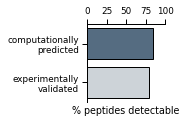

In [40]:
fig, ax = plt.subplots(figsize = (2.6, 1.8))
sns.barplot(data=(comb.sum()/comb.shape[0]*100).reset_index(), 
            y='index', 
            x=0, 
            ax = ax, 
            palette = hcmv_palette([10, 200]),
            linewidth=1, edgecolor='k',
           )

ax.set_xlim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.xaxis.tick_top()
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(['computationally\npredicted', 'experimentally\nvalidated'])
ax.set_ylabel('')
ax.set_xlabel('% peptides detectable')
fig.tight_layout()
fig.savefig(r'..\figures\Fig6F.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 6G

In [58]:
a = comb['pred']==comb['exp']
b = comb['pred'] == True

print('There are {} peptides computationally predicted to be present in HCMV TB40/E'.format(b.sum()))
print('There are {} peptides computationally predicted to be absent in HCMV TB40/E'.format((~b).sum()))
print('There are {} peptides computationally predicted and experimentally detected HCMV TB40/E'.format(comb['exp'][a&b].sum()))
print('There are {} peptides computationally predicted but NOT experimentally detected HCMV TB40/E'.format(((~a)&b).sum()))
print('There are {} peptides computationally predicted to be absent that were NOT experimentally detected HCMV TB40/E'.format(((a)&(~b)).sum()))



There are 189 peptides computationally predicted to be present in HCMV TB40/E
There are 34 peptides computationally predicted to be absent in HCMV TB40/E
There are 176 peptides computationally predicted and experimentally detected HCMV TB40/E
There are 13 peptides computationally predicted but NOT experimentally detected HCMV TB40/E
There are 34 peptides computationally predicted to be absent that were NOT experimentally detected HCMV TB40/E


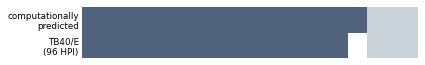

In [60]:
a = 5
b = 2

agree = comb['pred']==comb['exp']
y = comb['pred']==True
n = comb['pred']==False

a = np.where(agree&y, 'agree--yes', np.nan)
b = np.where(agree&n, 'agree--no', np.nan)
c = np.where(~agree&y, 'disagree--yes', np.nan)

temp = comb.copy()
temp['label'] = pd.DataFrame(np.vstack([a, b, c]).T, index = comb.index).stack().where(lambda x: x!='nan', np.nan).dropna().reset_index(level=-1, drop=True)
temp = temp.reset_index().set_index(['label']+temp.index.names).sort_index().astype(int)
temp.loc['disagree--yes', 'exp'] = np.nan
comb_temp = temp.loc[['agree--yes', 'disagree--yes', 'agree--no'], :]

fig, ax = plt.subplots(figsize=(6, 1))
sns.heatmap(comb_temp.T, 
            cmap = sns.blend_palette([hcmv_palette(200), pal[1]], as_cmap=True), 
            yticklabels = ['computationally\npredicted', 'TB40/E\n(96 HPI)'], 
            xticklabels = [],
            linewidths=0,
            cbar=False,
            ax=ax)
ax.set_xlabel('')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tick_params(size=0)
fig.tight_layout()
fig.savefig(r'..\figures\Fig6G.png', dpi=1000, bbox_inches='tight')
plt.show()
